# Road Traffic Signs - Bounding Box Predictions

In [23]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
import random
import os
import cv2 as cv
import seaborn as sns
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
ann_path = '/content/drive/MyDrive/DATASET/Road sign detection/annotations/'
img_path = '/content/drive/MyDrive/DATASET/Road sign detection/images/'

# Prepare the Training Dataframe

In [26]:
def get_file_list(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

In [27]:
def get_train_df(ann_path, img_path):
    ann_path_list = get_file_list(ann_path, '.xml')
    ann_list = []
    for a_path in ann_path_list:
        root = ET.parse(a_path).getroot()
        ann = {}
        #ann['filename'] = Path(str(img_path) + '/'+ root.find("./filename").text)
        ann['filename'] =  root.find("./filename").text
        ann['width'] = root.find("./size/width").text
        ann['height'] = root.find("./size/height").text
        #ann['class'] = root.find("./object/name").text
        ann['xmin'] = int(root.find("./object/bndbox/xmin").text)
        ann['ymin'] = int(root.find("./object/bndbox/ymin").text)
        ann['xmax'] = int(root.find("./object/bndbox/xmax").text)
        ann['ymax'] = int(root.find("./object/bndbox/ymax").text)
        ann_list.append(ann)
    return pd.DataFrame(ann_list)

In [28]:
df_train = get_train_df(ann_path, img_path)

In [29]:
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
idx_to_class = {k:v for k,v in enumerate(list(class_dict.keys()))}
#df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [30]:
df_train.head()

,filename,width,height,xmin,ymin,xmax,ymax
0,road0.png,267,400,98,62,208,232
1,road1.png,400,283,154,63,258,281
2,road10.png,400,267,106,3,244,263
3,road107.png,320,400,90,37,233,232
4,road104.png,400,364,48,14,344,345


In [31]:
len(df_train)

877

# Normalisation taille image

In [32]:
h=[]
w=[]
for i in tqdm(range(len(df_train))):
    h.append(df_train['height'][i])
    w.append(df_train['width'][i])


100%|██████████| 877/877 [00:00<00:00, 54945.03it/s]


On considere que les images font en moyenne 400x400

In [33]:
img_shape = (400,400,3)

In [34]:
def resize_the_img(img):
    img_resized = cv.resize(img, (img_shape[0],img_shape[1]))
    return img_resized

In [35]:
def read_img_and_points(filename):
    img = cv.imread(img_path+filename)
    #img = img/255
    img_resized = resize_the_img(img)
    for i in range(len(df_train)):
        if (df_train['filename'][i] == filename):
            ind = i
    points=[]
    
    xmin = df_train['xmin'][ind]/int(df_train['width'][ind])
    ymin = df_train['ymin'][ind]/int(df_train['height'][ind])
    xmax = df_train['xmax'][ind]/int(df_train['width'][ind])
    ymax = df_train['ymax'][ind]/int(df_train['height'][ind])

    points.append(round(xmin,2))
    points.append(round(ymin,2))
    points.append(round(xmax,2))
    points.append(round(ymax,2))


    return(img_resized,points)

In [36]:
def flip_vertical_img(image,points):
    flip_vertical_points=[]
    flip_vertical_points.append(1-points[2])
    flip_vertical_points.append(points[1])
    flip_vertical_points.append(1-points[0])   
    flip_vertical_points.append(points[3])
    flipVertical = cv.flip(image, 1)
    return flipVertical, flip_vertical_points


In [37]:
'''
for i in range(5):
    img, bb_points = read_img_and_points(df_train['filename'][i])
    fliped_img, flip_points = flip_img(img,bb_points)
    visualize_img_points(fliped_img,flip_points)
'''

"\nfor i in range(5):\n    img, bb_points = read_img_and_points(df_train['filename'][i])\n    fliped_img, flip_points = flip_img(img,bb_points)\n    visualize_img_points(fliped_img,flip_points)\n"

In [38]:
def flip_horizontal_img(image,points):
    flip_horizontal_points=[]
    flip_horizontal_points.append(points[0])
    flip_horizontal_points.append(1-points[3])
    flip_horizontal_points.append(points[2])   
    flip_horizontal_points.append(1-points[1])   
    flipHorizontal = cv.flip(image, 0)
    return flipHorizontal, flip_horizontal_points

In [39]:
'''
for i in range(5):
    img, bb_points = read_img_and_points(df_train['filename'][i])
    fliped_img, flip_points = flip_horizontal_img(img,bb_points)
    visualize_img_points(fliped_img,flip_points)
'''

"\nfor i in range(5):\n    img, bb_points = read_img_and_points(df_train['filename'][i])\n    fliped_img, flip_points = flip_horizontal_img(img,bb_points)\n    visualize_img_points(fliped_img,flip_points)\n"

In [40]:
def visualize_img_points(image,points):
    
    xmin = int(points[0]*img_shape[0]) # x bb
    ymin = int(points[1]*img_shape[1]) # y bb
    xmax = int(points[2]*img_shape[0])
    ymax = int(points[3]*img_shape[1])


    cv.circle(image, (xmin,ymin), 2, (255,0,0), 2)
    cv.circle(image, (xmax,ymax), 2, (0,0,255), 2)
    cv.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 2)

    plt.imshow(image)
    plt.show()

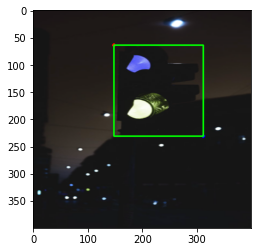

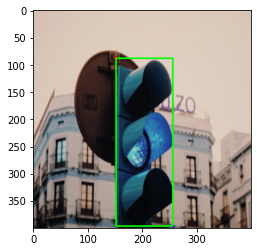

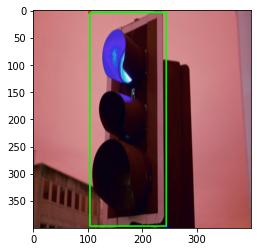

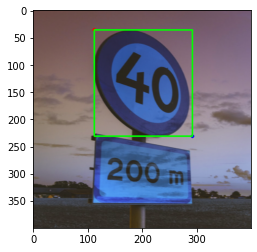

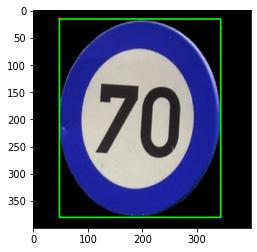

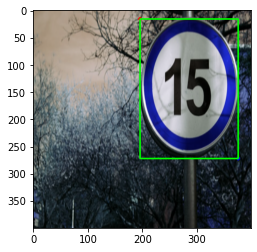

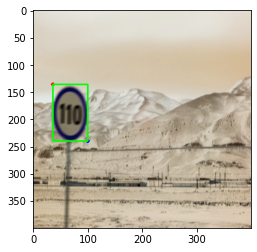

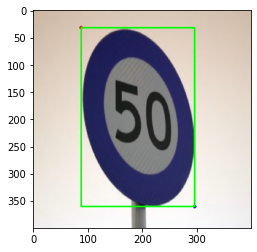

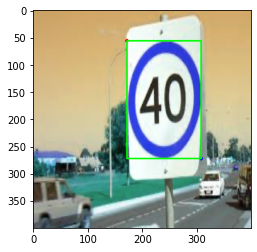

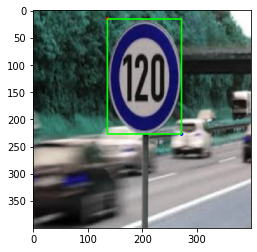

In [41]:
for i in range (10):
    img, points = read_img_and_points(df_train['filename'][i])
    visualize_img_points(img,points)

In [42]:
train_image = []
train_points = []
for name in tqdm(df_train['filename']):
  img,points = read_img_and_points(name)
  #img = np.expand_dims(img, axis=0)
  train_points.append(points)
  train_image.append(img)

100%|██████████| 877/877 [00:17<00:00, 50.86it/s]


In [43]:
train_image_arr =  np.array(train_image)
print(train_image_arr.shape)
train_points_arr =  np.array(train_points)
print(train_points_arr.shape)

(877, 400, 400, 3)
(877, 4)


In [1]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_image_arr, train_points_arr, test_size=0.1, random_state=42)

NameError: ignored

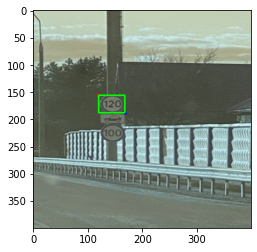

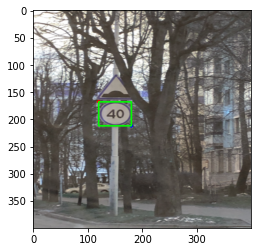

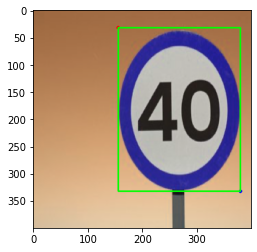

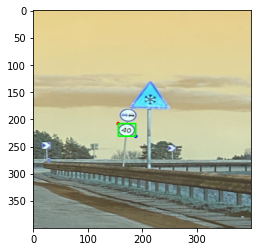

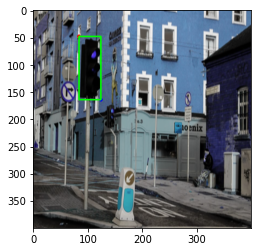

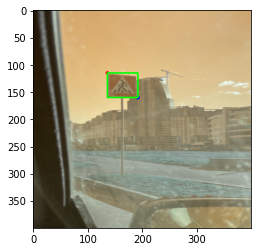

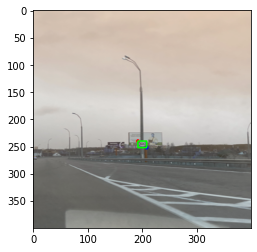

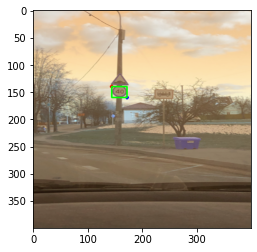

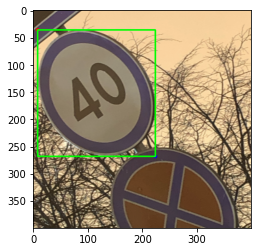

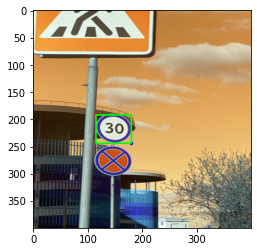

In [67]:
for i in range (10):
    visualize_img_points(X_train[i],y_train[i])

In [68]:
'''
from itertools import chain
from itertools import islice

#BATCH_SIZE = 32
BATCH_SIZE = 8

def batch_generator(filenames, batch_size):
    iterator = iter(filenames)
    for first in iterator:
        #print(first)        
        yield list(chain([first], islice(iterator, batch_size - 1)))
'''

'\nfrom itertools import chain\nfrom itertools import islice\n\n#BATCH_SIZE = 32\nBATCH_SIZE = 8\n\ndef batch_generator(filenames, batch_size):\n    iterator = iter(filenames)\n    for first in iterator:\n        #print(first)        \n        yield list(chain([first], islice(iterator, batch_size - 1)))\n'

In [69]:
'''
def train_generator(files):
    while True:
        for batch in batch_generator(files, BATCH_SIZE):
            # prepare batch images
            batch_imgs = []
            batch_targets = []
            for filename in batch:
                witch_flip = random.randint(0,2)
                img, points = read_img_and_points(filename)
                if witch_flip == 0:
                    img, points = flip_vertical_img(image,points)
                if witch_flip == 1:
                    img, points = flip_horizontal_img(filename)

                batch_imgs.append(img)
                batch_targets.append(points)
            # stack images into 4D tensor [batch_size, img_size, img_size, 3]
            batch_imgs = np.stack(batch_imgs, axis=0)
            print('batch_imgs.shape :',batch_imgs.shape)
            # convert targets into 2D tensor [batch_size, num_classes]
            batch_targets = np.stack(batch_targets, axis=0)
            #print('batch_target.shape :',batch_targets.shape)

            yield batch_imgs, batch_targets
'''

"\ndef train_generator(files):\n    while True:\n        for batch in batch_generator(files, BATCH_SIZE):\n            # prepare batch images\n            batch_imgs = []\n            batch_targets = []\n            for filename in batch:\n                witch_flip = random.randint(0,2)\n                img, points = read_img_and_points(filename)\n                if witch_flip == 0:\n                    img, points = flip_vertical_img(image,points)\n                if witch_flip == 1:\n                    img, points = flip_horizontal_img(filename)\n\n                batch_imgs.append(img)\n                batch_targets.append(points)\n            # stack images into 4D tensor [batch_size, img_size, img_size, 3]\n            batch_imgs = np.stack(batch_imgs, axis=0)\n            print('batch_imgs.shape :',batch_imgs.shape)\n            # convert targets into 2D tensor [batch_size, num_classes]\n            batch_targets = np.stack(batch_targets, axis=0)\n            #print('batch_targ

In [70]:
'''
for imgs, points in train_generator(X_train):
    for img, point in zip(imgs,points):
        visualize_img_points(img,point)
    break
'''

'\nfor imgs, points in train_generator(X_train):\n    for img, point in zip(imgs,points):\n        visualize_img_points(img,point)\n    break\n'

In [71]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, InputLayer, LeakyReLU, Dropout


model = keras.models.Sequential()
model.add(Conv2D(filters=32, kernel_size=(2,2), input_shape=(400, 400, 3), activation='relu')) 
model.add(Conv2D(filters=32, kernel_size=(3,3),  activation='relu')) 
model.add(Conv2D(filters=32, kernel_size=(3,3),  activation='relu')) 
model.add(Dropout(0.25))

model.add(MaxPooling2D(pool_size = (2,2)))   
model.add(Conv2D(filters=64, kernel_size=(2,2), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(Dropout(0.25))

model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))

model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(500, activation='relu'))

model.add(Dropout(0.25))
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))


model.add(Dropout(0.25))
model.add(Dense(4))  

model.compile(loss='mse',optimizer = 'adam', metrics='mse')

In [73]:
model.fit(X_train,y_train, epochs = 3,batch_size=16, validation_data=(X_test,y_test))

Epoch 1/3
50/50 [==============================] - 31s 627ms/step - loss: 265.3885 - mse: 265.3885 - val_loss: 0.1951 - val_mse: 0.1951
Epoch 2/3
50/50 [==============================] - 31s 620ms/step - loss: 0.1339 - mse: 0.1339 - val_loss: 0.1396 - val_mse: 0.1396
Epoch 3/3
50/50 [==============================] - 31s 616ms/step - loss: 0.0576 - mse: 0.0576 - val_loss: 0.0248 - val_mse: 0.0248


In [74]:
for i in range( 80 ):
  img_test = X_test[i]
  img_test = np.expand_dims(img_test, axis=0)
  pred = model.predict(img_test)[0]
  visualize_img_points(X_test[i],pred)


Output hidden; open in https://colab.research.google.com to view.

In [75]:
img_test = np.array(X_test)
#img_test = np.expand_dims(img_test, axis=0)
print(img_test.shape)
pred = model.predict(img_test)

(88, 400, 400, 3)


In [76]:
pred

array([[0.36010742, 0.36568508, 0.5552442 , 0.5439141 ],
       [0.36010742, 0.36568508, 0.5552442 , 0.5439141 ],
       [0.36010742, 0.36568508, 0.5552442 , 0.5439141 ],
       [0.36010742, 0.36568508, 0.5552442 , 0.5439141 ],
       [0.36010742, 0.36568508, 0.5552442 , 0.5439141 ],
       [0.36010742, 0.36568508, 0.5552442 , 0.5439141 ],
       [0.36010742, 0.36568508, 0.5552442 , 0.5439141 ],
       [0.36010742, 0.36568508, 0.5552442 , 0.5439141 ],
       [0.36010742, 0.36568508, 0.5552442 , 0.5439141 ],
       [0.36010742, 0.36568508, 0.5552442 , 0.5439141 ],
       [0.36010742, 0.36568508, 0.5552442 , 0.5439141 ],
       [0.36010742, 0.36568508, 0.5552442 , 0.5439141 ],
       [0.30317324, 0.31893122, 0.4759446 , 0.45947456],
       [0.35750902, 0.3633422 , 0.55190706, 0.5403694 ],
       [0.36010742, 0.36568508, 0.5552442 , 0.5439141 ],
       [0.36010742, 0.36568508, 0.5552442 , 0.5439141 ],
       [0.36010742, 0.36568508, 0.5552442 , 0.5439141 ],
       [0.3600977 , 0.3656304 ,